In [1]:
import os.path as op
import pickle
import copy
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from scipy.ndimage import gaussian_filter
from matplotlib.colors import ListedColormap
from scipy.stats import spearmanr, linregress
from joblib import Parallel, delayed
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests
from poisson_glm_granger import compute_granger_causality, permutation_test
from numpy.linalg import norm
import os

In [2]:
pipeline='NEARICA_behav'
epoch_types=['eye','task']
excluded_subjects=np.array(['C34','C36'])
left_handers=np.array(['C23','C13','C20','C40','C43','C46'])
groups=['typ','dcd']

In [3]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

def add_subplot_label(ax, label, x=-.21, y=1.225):
    ax.text(x, y, label,  # Adjust left of y-axis
            transform=ax.transAxes,
            fontsize=26, va='top', ha='right')

typ_color=np.array([27,158,119])/255.0
dcd_color=np.array([117,112,179])/255.0

In [4]:
exclude_typ=[]

all_bursts={
    'subject': [],
    'group': [],
    'epoch_type': [],
    'condition': [],
    'hemi': [],
    'cluster': [],
    'trial': [],
    'waveform': np.zeros((0,130)),
    'waveform_times': [],
    'peak_freq': [],
    'peak_amp_iter': [],
    'peak_amp_base': [],
    'peak_time': [],
    'peak_adjustment': [],
    'fwhm_freq': [],
    'fwhm_time': [],
    'polarity': [],
}

subjects = pd.read_csv('/home/bonaiuto/dcd_ross/data/participants.tsv', sep='\t')
df, meta = pyreadstat.read_sav('/home/bonaiuto/dcd_ross/CoMB_Dataset.sav')

subject_ids = subjects['participant_id']
for subj_id in subject_ids:
    group=df['Group'][np.where(df['SubjectID']==subj_id)[0]].values[0]
    mab_per=df['MABC_Percentile'][np.where(df['SubjectID']==subj_id)[0]].values[0]        
    if group==0 and mab_per<25:
        exclude_typ.append(subj_id)
        
    if not len(np.where(excluded_subjects==subj_id)[0]):
        subject_data_dir=op.join('/home/bonaiuto/dcd_ross/data/derivatives', pipeline, subj_id, 'processed_data')
        for epoch_type in epoch_types:
            for cluster in ['C3','C4']:
                if cluster=='C3':
                    if np.isin(subj_id,left_handers):
                        hemi='ipsi'
                    else:
                        hemi='contra'
                else:
                    if np.isin(subj_id,left_handers):
                        hemi='contra'
                    else:
                        hemi='ipsi'
                fname=op.join(subject_data_dir, f'bursts_{subj_id}_{epoch_type}_{cluster}.pickle')
                if op.exists(fname):
                    with open(fname,'rb') as file:
                        bursts=pickle.load(file)
                    n_bursts=len(bursts['trial'])
                    bursts['group']=np.array([group for i in range(n_bursts)])
                    bursts['hemi']=np.array([hemi for i in range(n_bursts)])
                    bursts['cluster']=np.array([cluster for i in range(n_bursts)])
                    for key in bursts.keys():
                        if key=='waveform_times':
                            all_bursts[key] = bursts[key]
                        elif key=='waveform':
                            all_bursts[key] = np.vstack([all_bursts[key], bursts[key]])
                        else:
                            all_bursts[key] = np.hstack([all_bursts[key], bursts[key]])
    else:
        print(f'skipping {subj_id}')

skipping C34
skipping C36


In [5]:
include_typ_idx = ~np.isin(all_bursts['subject'], exclude_typ)
typ_idx=np.where(include_typ_idx & (all_bursts['group']==0))[0]
dcd_idx=np.where(all_bursts['group']==1)[0]

In [6]:
n_typ=len(np.unique(all_bursts['subject'][typ_idx]))
n_dcd=len(np.unique(all_bursts['subject'][dcd_idx]))
print(f'N typical={n_typ}')
print(f'N DCD={n_dcd}')

N typical=24
N DCD=21


In [7]:
burst_times=all_bursts['waveform_times']
pca = PCA(n_components=20)
burst_std=RobustScaler().fit_transform(all_bursts['waveform'])
pca=pca.fit(burst_std[include_typ_idx,:])
pcs = pca.transform(burst_std)


pca_components = pd.DataFrame(pcs)

In [8]:
n_pc_bins=4
region_labels=['ipsi','contra']
unit_labels=[]
for region in region_labels:
    for q in range(n_pc_bins):
        unit_labels.append(f'{region}-{q+1}')

In [9]:
conditions=['obs fine','obs gross','exe fine','exe gross']
events=['E 17','E 18','E 33','E 34']

min_trials=10
trial_dur=10
step=100/n_pc_bins
pc_idx=6
pc_bins = np.percentile(pca_components[pc_idx], np.arange(0,100+step,step))
    
time_bin_size = .005
time_bins = np.arange(0, trial_dur + time_bin_size, time_bin_size)

all_binned_bursts={
    'typ': [],
    'dcd': []
}
group_subjs={}
subjects = np.unique(all_bursts['subject'])
for g_idx, group in enumerate(groups):
    group_subj = np.unique(all_bursts['subject'][np.where(all_bursts['group'] == g_idx)[0]])
    group_subjs[group]=[]
    for subject in group_subj:
        if ~np.isin(subject, exclude_typ):
            group_subjs[group].append(subject)
            subj_idx = (all_bursts['subject'] == subject)
            subject_binned_bursts=[]
            for hemi in ['ipsi','contra']:
                region_idx=(all_bursts['hemi'].astype(str)==hemi)
                for q in range(n_pc_bins):
                    q_idx = (pca_components[pc_idx] >= pc_bins[q]) & (pca_components[pc_idx] <= pc_bins[q+1])
                    unit_bursts=[]
                    for condition, event in zip(conditions, events):
                        cond_trials = np.unique(all_bursts['trial'][subj_idx & (all_bursts['condition'] == event)])
                        if len(cond_trials)>=min_trials:
                            for t_idx,trial in enumerate(cond_trials):
                                b_idx = subj_idx & (all_bursts['condition']==event) & region_idx & q_idx & (all_bursts['trial']==trial)
                                binned_bursts, _ = np.histogram(all_bursts['peak_time'][b_idx], bins=time_bins)
                                unit_bursts.append(binned_bursts)
                    
                    subject_binned_bursts.append(unit_bursts)
            subject_binned_bursts=np.array(subject_binned_bursts)
            if subject_binned_bursts.shape[1]>0:
                all_binned_bursts[group].append(subject_binned_bursts)


In [185]:
optimal_lags={
    'typ': [],
    'dcd': [],
}
gc_matrices={
    'typ': [],
    'dcd': [],
}
signed_gc_matrices={
    'typ': [],
    'dcd': [],
}
for group in groups:
    for s_idx in range(len(all_binned_bursts[group])):
        print(f'{group} - {s_idx}')
        X=all_binned_bursts[group][s_idx]
        print(X.shape)

        optimal_lag, gc_matrix, signed_gc_matrix = compute_granger_causality(
            X,
            lags=np.arange(1,10), 
            folds=10,
            n_jobs=20
        )
        
        optimal_lags[group].append(optimal_lag)
        gc_matrices[group].append(gc_matrix)
        signed_gc_matrices[group].append(signed_gc_matrix)


typ - 0
(8, 51, 2001)
Data contains 8 neurons, 51 trials, and 2001 time steps.
typ - 1
(8, 28, 2001)
Data contains 8 neurons, 28 trials, and 2001 time steps.
typ - 2
(8, 74, 2001)
Data contains 8 neurons, 74 trials, and 2001 time steps.
typ - 3
(8, 71, 2001)
Data contains 8 neurons, 71 trials, and 2001 time steps.
typ - 4
(8, 30, 2001)
Data contains 8 neurons, 30 trials, and 2001 time steps.
typ - 5
(8, 62, 2001)
Data contains 8 neurons, 62 trials, and 2001 time steps.
typ - 6
(8, 10, 2001)
Data contains 8 neurons, 10 trials, and 2001 time steps.
typ - 7
(8, 78, 2001)
Data contains 8 neurons, 78 trials, and 2001 time steps.
typ - 8
(8, 74, 2001)
Data contains 8 neurons, 74 trials, and 2001 time steps.
typ - 9
(8, 75, 2001)
Data contains 8 neurons, 75 trials, and 2001 time steps.
typ - 10
(8, 80, 2001)
Data contains 8 neurons, 80 trials, and 2001 time steps.
typ - 11
(8, 76, 2001)
Data contains 8 neurons, 76 trials, and 2001 time steps.
typ - 12
(8, 50, 2001)
Data contains 8 neurons, 50

In [10]:
granger_res_fname='./data/derivatives/NEARICA_behav/granger_results.npz'

In [187]:
np.savez(
    granger_res_fname,
    optimal_lags=optimal_lags,
    gc_matrices=gc_matrices,
    signed_gc_matrices=signed_gc_matrices
)

In [11]:
loaded_data = np.load(granger_res_fname, allow_pickle=True)
optimal_lags = loaded_data['optimal_lags'].item()
gc_matrices = loaded_data['gc_matrices'].item()
signed_gc_matrices = loaded_data['signed_gc_matrices'].item()

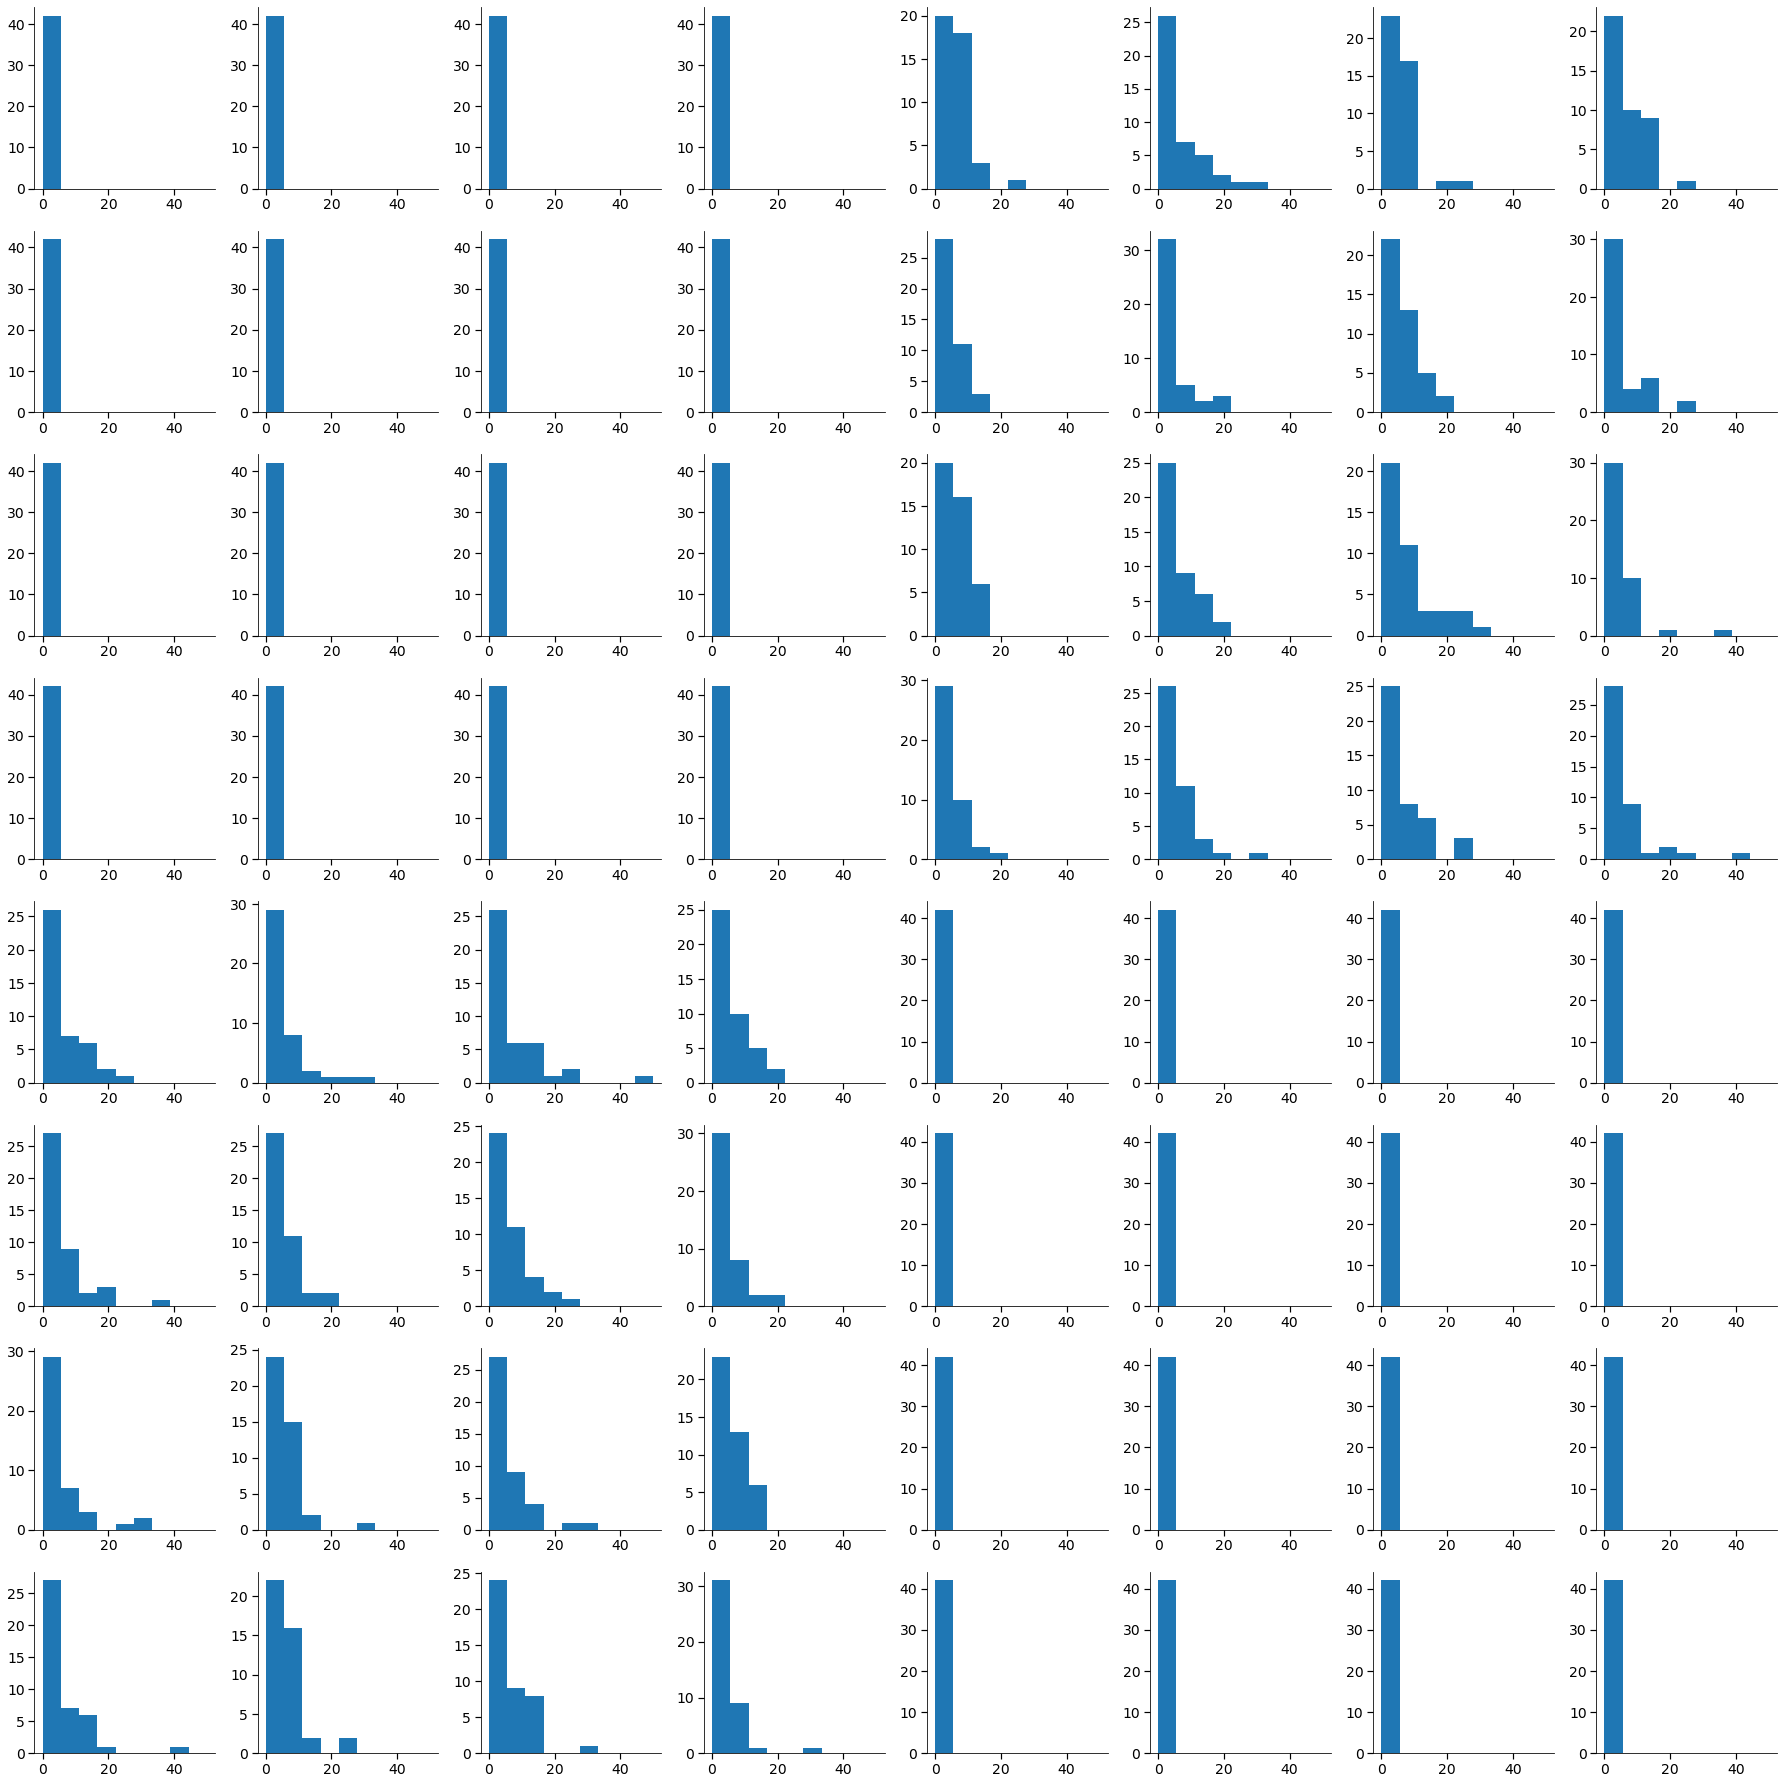

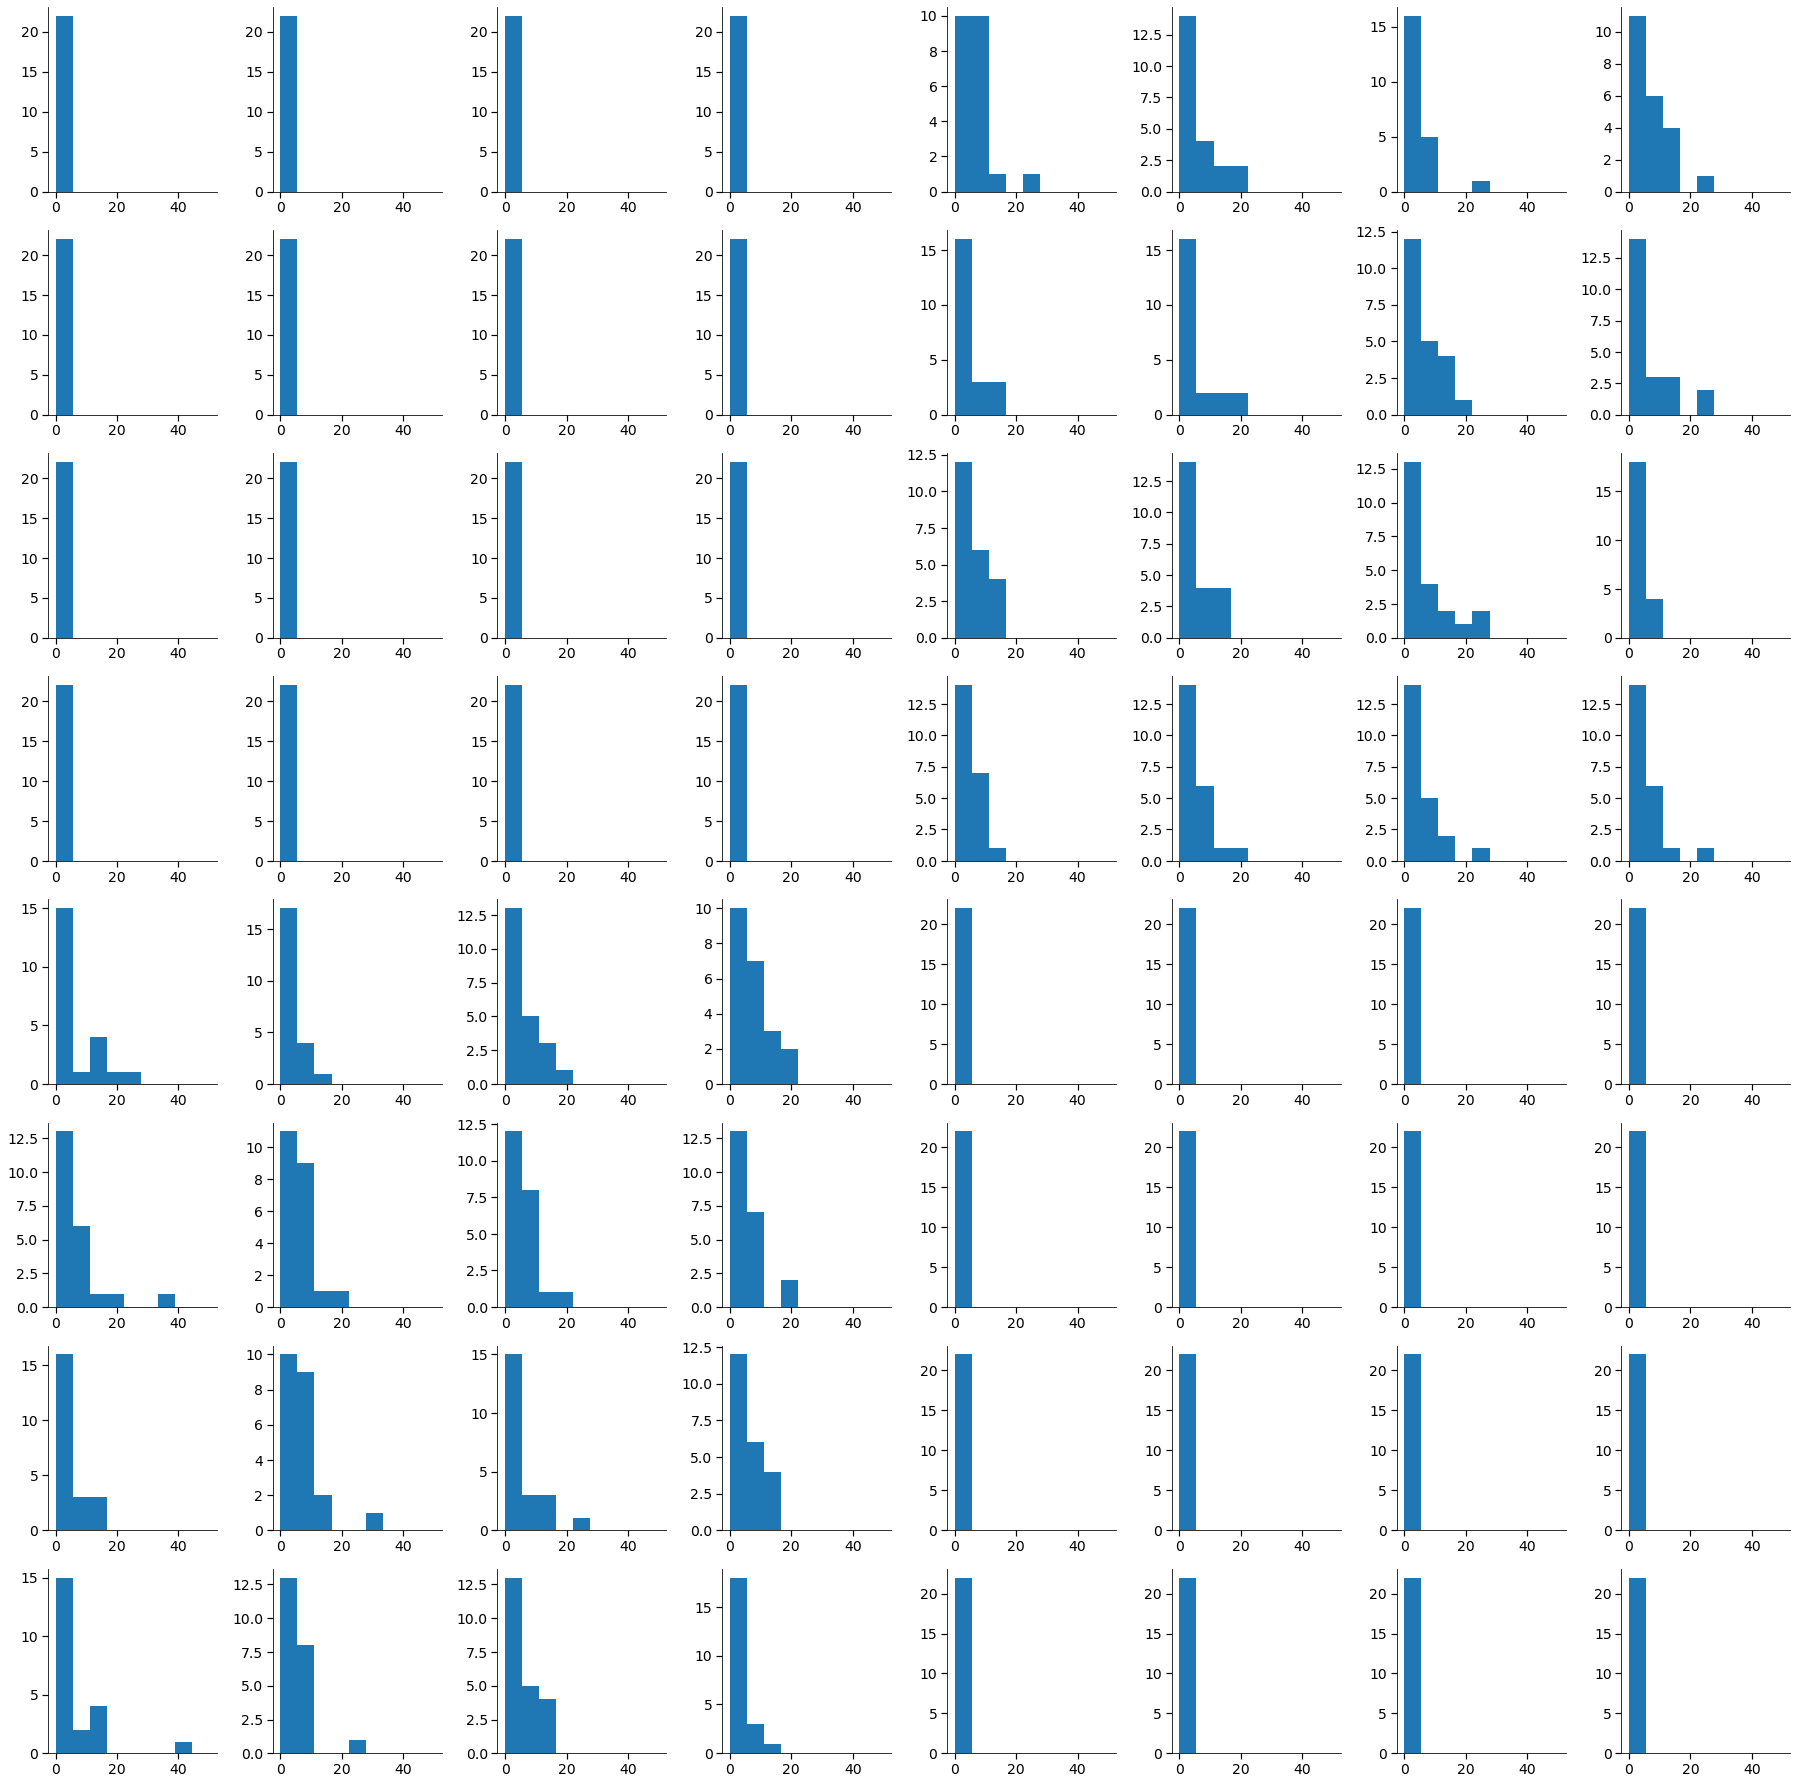

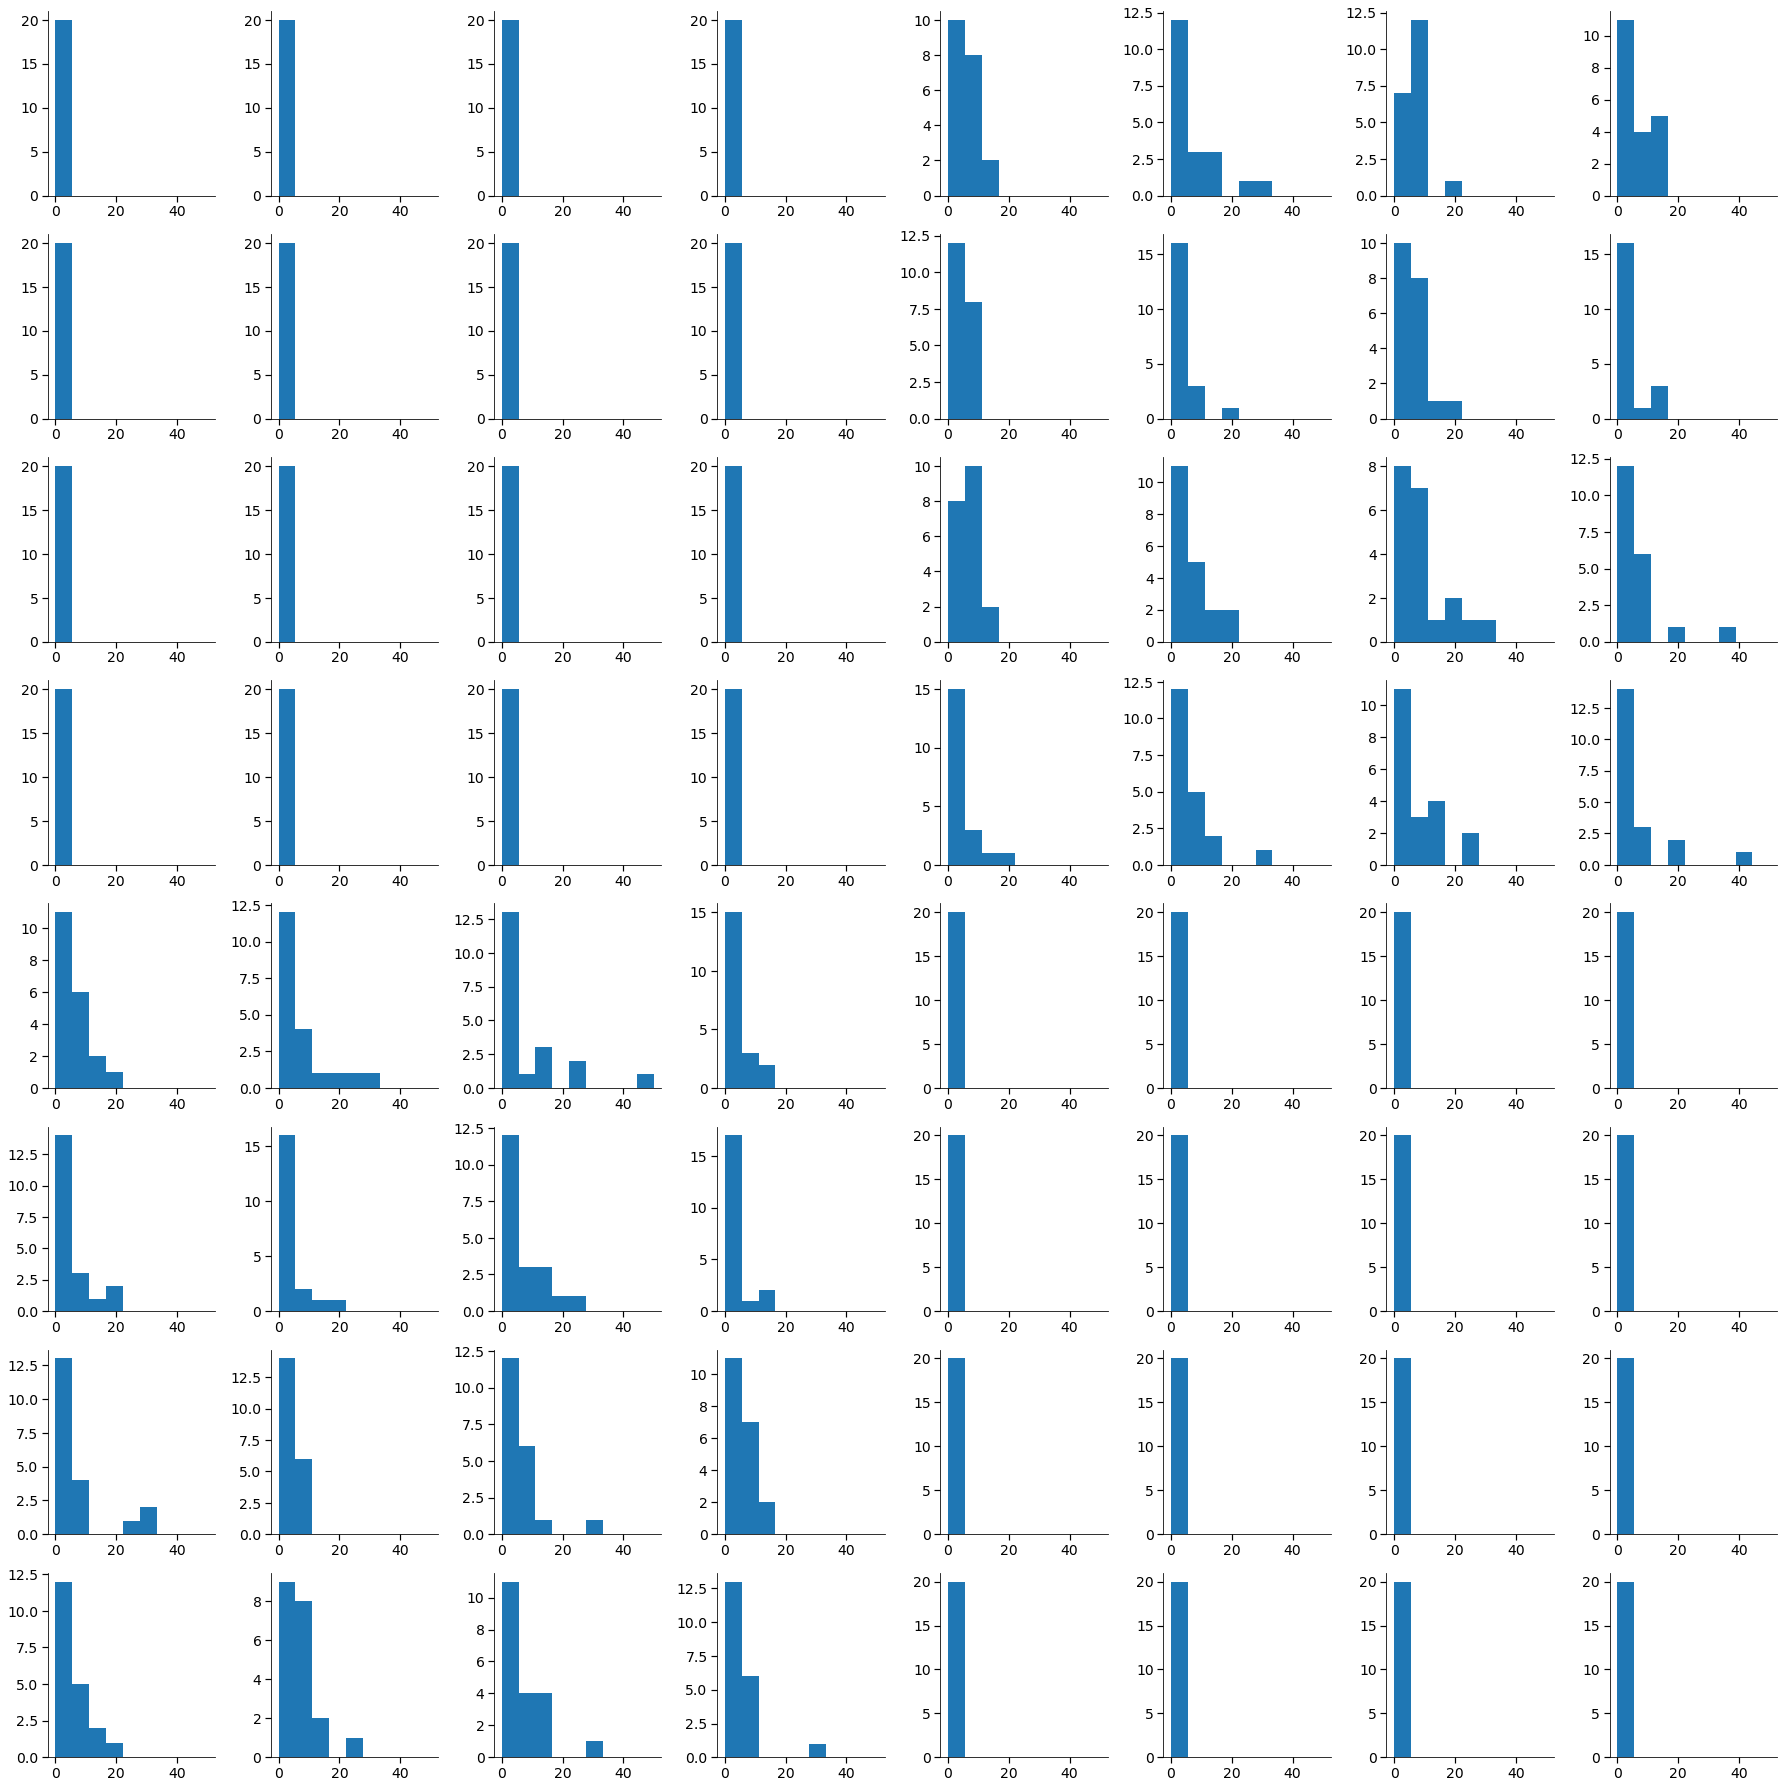

In [12]:
bins=np.linspace(0, 10*time_bin_size*1000,10)
        
fig=plt.figure(figsize=(25,25)) 
gs = GridSpec(len(unit_labels), len(unit_labels))
for source in range(len(unit_labels)):
    for target in range(len(unit_labels)):
        ax = fig.add_subplot(gs[source,target])
        conn_lags=[]
        for group in groups:
            for x in optimal_lags[group]:
                conn_lags.append(x[(source,target)][0]*time_bin_size*1000)
        plt.hist(conn_lags,bins)
        
plt.tight_layout()

fig=plt.figure(figsize=(25,25)) 
gs = GridSpec(len(unit_labels), len(unit_labels))
for source in range(len(unit_labels)):
    for target in range(len(unit_labels)):
        ax = fig.add_subplot(gs[source,target])
        plt.hist([x[(source,target)][0]*time_bin_size*1000 for x in optimal_lags['typ']],bins)
        
plt.tight_layout()

fig=plt.figure(figsize=(25,25)) 
gs = GridSpec(len(unit_labels), len(unit_labels))
for source in range(len(unit_labels)):
    for target in range(len(unit_labels)):
        ax = fig.add_subplot(gs[source,target])
        plt.hist([x[(source,target)][0]*time_bin_size*1000 for x in optimal_lags['dcd']],bins)
        
plt.tight_layout()


In [22]:
n_permutations = 1000
alpha = 0.05
n_units = gc_matrices[groups[0]][0].shape[0]


In [466]:
def shuffle_trials(data):
    """
    Shuffle trials for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled trials.
    """
    shuffled_data = data.copy()
    neurons, trials, _ = shuffled_data.shape

    for neuron in range(neurons):
        shuffled_data[neuron, :, :] = shuffled_data[neuron, np.random.permutation(trials), :]
    return shuffled_data


def shuffle_time(data):
    """
    Shuffle time points for all neurons in the data array.

    Parameters:
    ----------
    data : ndarray
        The input data array of shape (neurons, trials, time_steps).

    Returns:
    -------
    ndarray
        A shuffled version of the input data with shuffled time points.
    """
    shuffled_data = data.copy()
    neurons, _, time_steps = shuffled_data.shape

    for neuron in range(neurons):
        for trial in range(shuffled_data.shape[1]):
            shuffled_data[neuron, trial, :] = np.random.permutation(shuffled_data[neuron, trial, :])
    return shuffled_data


# Permutation test with separate shuffling for trials and time
permuted_gc_matrices = {group: [] for group in groups}
permuted_signed_gc_matrices = {group: [] for group in groups}

# Run permutations one at a time to avoid large memory usage
for perm_idx in range(n_permutations):
    for group in groups:
        n_group_subjects=len(binned_bursts[group])
        permuted_gc_matrix = np.zeros((n_group_subjects, n_units, n_units))
        permuted_signed_gc_matrix = np.zeros((n_group_subjects, n_units, n_units))
        
        for s_idx in range(n_group_subjects):
            subject_data=binned_bursts[group][s_idx]
            print(f'Permutation {perm_idx}, Group {group}, Subject {s_idx}')

            # Shuffle trials for off-diagonal elements
            shuffled_trials_X = shuffle_trials(subject_data)
            _, gc_trials, signed_gc_trials = compute_granger_causality(
                shuffled_trials_X,
                n_jobs=-1,
                pairwise_lags=optimal_lags[group][s_idx]
            )
            # Shuffle time for diagonal elements
            shuffled_time_X = shuffle_time(subject_data)
            _, gc_time, signed_gc_time = compute_granger_causality(
                shuffled_time_X,
                n_jobs=-1,
                pairwise_lags=optimal_lags[group][s_idx]
            )
            
            # Combine results: diagonal from time shuffling, off-diagonal from trial shuffling
            for i in range(n_units):
                for j in range(n_units):
                    if i == j:
                        permuted_gc_matrix[s_idx, i, j] = gc_time[i, j]
                        permuted_signed_gc_matrix[s_idx, i, j] = signed_gc_time[i, j]
                    else:
                        permuted_gc_matrix[s_idx, i, j] = gc_trials[i, j]
                        permuted_signed_gc_matrix[s_idx, i, j] = signed_gc_trials[i, j]

        # Average across subjects
        permuted_gc_matrices[group].append(np.mean(permuted_gc_matrix, axis=0))
        permuted_signed_gc_matrices[group].append(np.mean(permuted_signed_gc_matrix, axis=0))


Permutation 0, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 0, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data co

Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 1, Group typ, Subject 19


Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 2, Group dcd, Subject 10
Data c

Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 3, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 3, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 3, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 4, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 4, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 4, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 4, Group typ, Subject 3
Data

Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 5, Group typ, Subject 16


Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 6, Group dcd, Subject 7
Data co

Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 7, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 8, Group typ, Subject 0
D

Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 9, Group typ, Subject 13
Dat

Permutation 10, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 10, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 10, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 10, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 10, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 10, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 10, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time step

Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 11, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 11, Group dcd, Subj

Permutation 13, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 13, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.


Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 14, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 14, Group typ, Subj

Permutation 15, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 15, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps

Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 16, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 16, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 17, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 17, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 17, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 17, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 17, Group typ, Subject 

Permutation 18, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 18, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time 

Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 19, Group dcd, Subject 7


Permutation 20, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 20, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time 

Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 22, Group typ, Subject 

Permutation 23, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 23, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 23, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 23, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 23, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 23, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 23, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time ste

Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 24, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 24, Group dcd, Subje

Permutation 26, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 26, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.


Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 27, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 27, Group typ, Subj

Permutation 28, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 28, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.

Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 29, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 29, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 29, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 30, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 30, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 30, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 30, Group typ, Subject

Permutation 31, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 31, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time s

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 32, Group dcd, Subject 6


Permutation 33, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 33, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time 

Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 35, Group typ, Subject 1

Permutation 36, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 36, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 36, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 36, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 36, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 36, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 36, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time st

Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 37, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 37, Group dcd, Subjec

Permutation 39, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 39, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.


Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 40, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 40, Group typ, Subj

Permutation 41, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 41, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.


Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 42, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 42, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 42, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 42, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 43, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 43, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 43, Group typ, Subjec

Permutation 44, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 44, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time st

Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 45, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 45, Group dcd, Subject 5

Permutation 46, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 46, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time 

Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 48, Group typ, Subject 10

Permutation 49, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 49, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 49, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 49, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 49, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 49, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 49, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time s

Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 50, Group dcd, Subject

Permutation 51, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 52, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 53, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 53, Group typ, Subj

Permutation 54, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 54, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.


Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 55, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 55, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 55, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 55, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 55, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 56, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 56, Group typ, Subje

Permutation 57, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 57, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time ste

Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 58, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 58, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 58, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 58, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 58, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 58, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 58, Group dcd, Subject 

Permutation 59, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 59, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time 

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 61, Group typ, Subject 9


Permutation 62, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 62, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time 

Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 63, Group dcd, Subject 

Permutation 64, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 64, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 65, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 65, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 65, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 65, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 65, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps

Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 66, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 66, Group typ, Subj

Permutation 67, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 67, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.


Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 68, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 69, Group typ, Subj

Permutation 70, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 70, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time step

Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 71, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 71, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 71, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 71, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 71, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 71, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 71, Group dcd, Subject

Permutation 72, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 72, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time s

Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 74, Group typ, Subject 8


Permutation 75, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 75, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time 

Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 76, Group dcd, Subject 1

Permutation 77, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 77, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 77, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 78, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 78, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 78, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 78, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time step

Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 79, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 79, Group typ, Subj

Permutation 80, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 80, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.


Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 81, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 81, Group dcd, Subj

Permutation 83, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 83, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 84, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 84, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 84, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 84, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 84, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 84, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 84, Group dcd, Subjec

Permutation 85, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 85, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time st

Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 87, Group typ, Subject 7


Permutation 88, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 88, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time 

Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 89, Group dcd, Subject 10

Permutation 90, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 90, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 90, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 90, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 91, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 91, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 91, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time ste

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 92, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 92, Group typ, Subje

Permutation 93, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 93, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.

Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 94, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 94, Group dcd, Subj

Permutation 96, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 96, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.

Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 97, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 97, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 97, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 97, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 97, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 97, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 97, Group dcd, Subje

Permutation 98, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 98, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time ste

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 100, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 100, Group typ, Sub

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 101, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 101, Group ty

Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 102, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 102, Group dcd, Sub

Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 103, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 104, Group ty

Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 105, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 105, Group typ, S

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 106, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 106, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 106, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 106, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 106, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 106, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 106, Group dcd,

Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 107, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 107, Group dcd,

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 109, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 109, Group typ, Sub

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 12
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 13
Data contains 8 neurons, 57 trials, and 2001 time steps.
Data contains 8 neurons, 57 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 14
Data contains 8 neurons, 77 trials, and 2001 time steps.
Data contains 8 neurons, 77 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 15
Data contains 8 neurons, 50 trials, and 2001 time steps.
Data contains 8 neurons, 50 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 110, Group typ, Subject 17
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 110, Group ty

Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 2
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 3
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 4
Data contains 8 neurons, 41 trials, and 2001 time steps.
Data contains 8 neurons, 41 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 5
Data contains 8 neurons, 44 trials, and 2001 time steps.
Data contains 8 neurons, 44 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 6
Data contains 8 neurons, 39 trials, and 2001 time steps.
Data contains 8 neurons, 39 trials, and 2001 time steps.
Permutation 111, Group dcd, Subject 7
Data contains 8 neurons, 13 trials, and 2001 time steps.
Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 111, Group dcd, Sub

Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 14
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 15
Data contains 8 neurons, 63 trials, and 2001 time steps.
Data contains 8 neurons, 63 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 16
Data contains 8 neurons, 65 trials, and 2001 time steps.
Data contains 8 neurons, 65 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 17
Data contains 8 neurons, 69 trials, and 2001 time steps.
Data contains 8 neurons, 69 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 18
Data contains 8 neurons, 60 trials, and 2001 time steps.
Data contains 8 neurons, 60 trials, and 2001 time steps.
Permutation 112, Group dcd, Subject 19
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 113, Group ty

Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 6
Data contains 8 neurons, 10 trials, and 2001 time steps.
Data contains 8 neurons, 10 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 7
Data contains 8 neurons, 78 trials, and 2001 time steps.
Data contains 8 neurons, 78 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 8
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 9
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 10
Data contains 8 neurons, 80 trials, and 2001 time steps.
Data contains 8 neurons, 80 trials, and 2001 time steps.
Permutation 114, Group typ, Subject 11
Data contains 8 neurons, 76 trials, and 2001 time steps.
Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 114, Group typ, S

Data contains 8 neurons, 76 trials, and 2001 time steps.
Permutation 115, Group typ, Subject 18
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 115, Group typ, Subject 19
Data contains 8 neurons, 75 trials, and 2001 time steps.
Data contains 8 neurons, 75 trials, and 2001 time steps.
Permutation 115, Group typ, Subject 20
Data contains 8 neurons, 54 trials, and 2001 time steps.
Data contains 8 neurons, 54 trials, and 2001 time steps.
Permutation 115, Group typ, Subject 21
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 115, Group dcd, Subject 0
Data contains 8 neurons, 66 trials, and 2001 time steps.
Data contains 8 neurons, 66 trials, and 2001 time steps.
Permutation 115, Group dcd, Subject 1
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 115, Group dcd,

Data contains 8 neurons, 13 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 8
Data contains 8 neurons, 64 trials, and 2001 time steps.
Data contains 8 neurons, 64 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 9
Data contains 8 neurons, 47 trials, and 2001 time steps.
Data contains 8 neurons, 47 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 10
Data contains 8 neurons, 72 trials, and 2001 time steps.
Data contains 8 neurons, 72 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 11
Data contains 8 neurons, 70 trials, and 2001 time steps.
Data contains 8 neurons, 70 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 12
Data contains 8 neurons, 61 trials, and 2001 time steps.
Data contains 8 neurons, 61 trials, and 2001 time steps.
Permutation 116, Group dcd, Subject 13
Data contains 8 neurons, 23 trials, and 2001 time steps.
Data contains 8 neurons, 23 trials, and 2001 time steps.
Permutation 116, Group dcd,

Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 0
Data contains 8 neurons, 51 trials, and 2001 time steps.
Data contains 8 neurons, 51 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 1
Data contains 8 neurons, 28 trials, and 2001 time steps.
Data contains 8 neurons, 28 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 2
Data contains 8 neurons, 74 trials, and 2001 time steps.
Data contains 8 neurons, 74 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 3
Data contains 8 neurons, 71 trials, and 2001 time steps.
Data contains 8 neurons, 71 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 4
Data contains 8 neurons, 30 trials, and 2001 time steps.
Data contains 8 neurons, 30 trials, and 2001 time steps.
Permutation 118, Group typ, Subject 5
Data contains 8 neurons, 62 trials, and 2001 time steps.
Data contains 8 neurons, 62 trials, and 2001 time steps.
Permutation 118, Group typ, Sub

In [23]:
shuffle_one_samp_res_fname='./data/derivatives/NEARICA_behav/granger_shuffled_one_samp_results.npz'

In [468]:
np.savez(
    shuffle_one_samp_res_fname,
    permuted_gc_matrices=permuted_gc_matrices,
    permuted_signed_gc_matrices=permuted_signed_gc_matrices
)

In [24]:
loaded_data = np.load(shuffle_one_samp_res_fname, allow_pickle=True)
permuted_gc_matrices = loaded_data['permuted_gc_matrices'].item()
permuted_signed_gc_matrices = loaded_data['permuted_signed_gc_matrices'].item()

In [25]:
n_permutations=len(permuted_gc_matrices['typ'])

In [26]:
n_permutations

1000

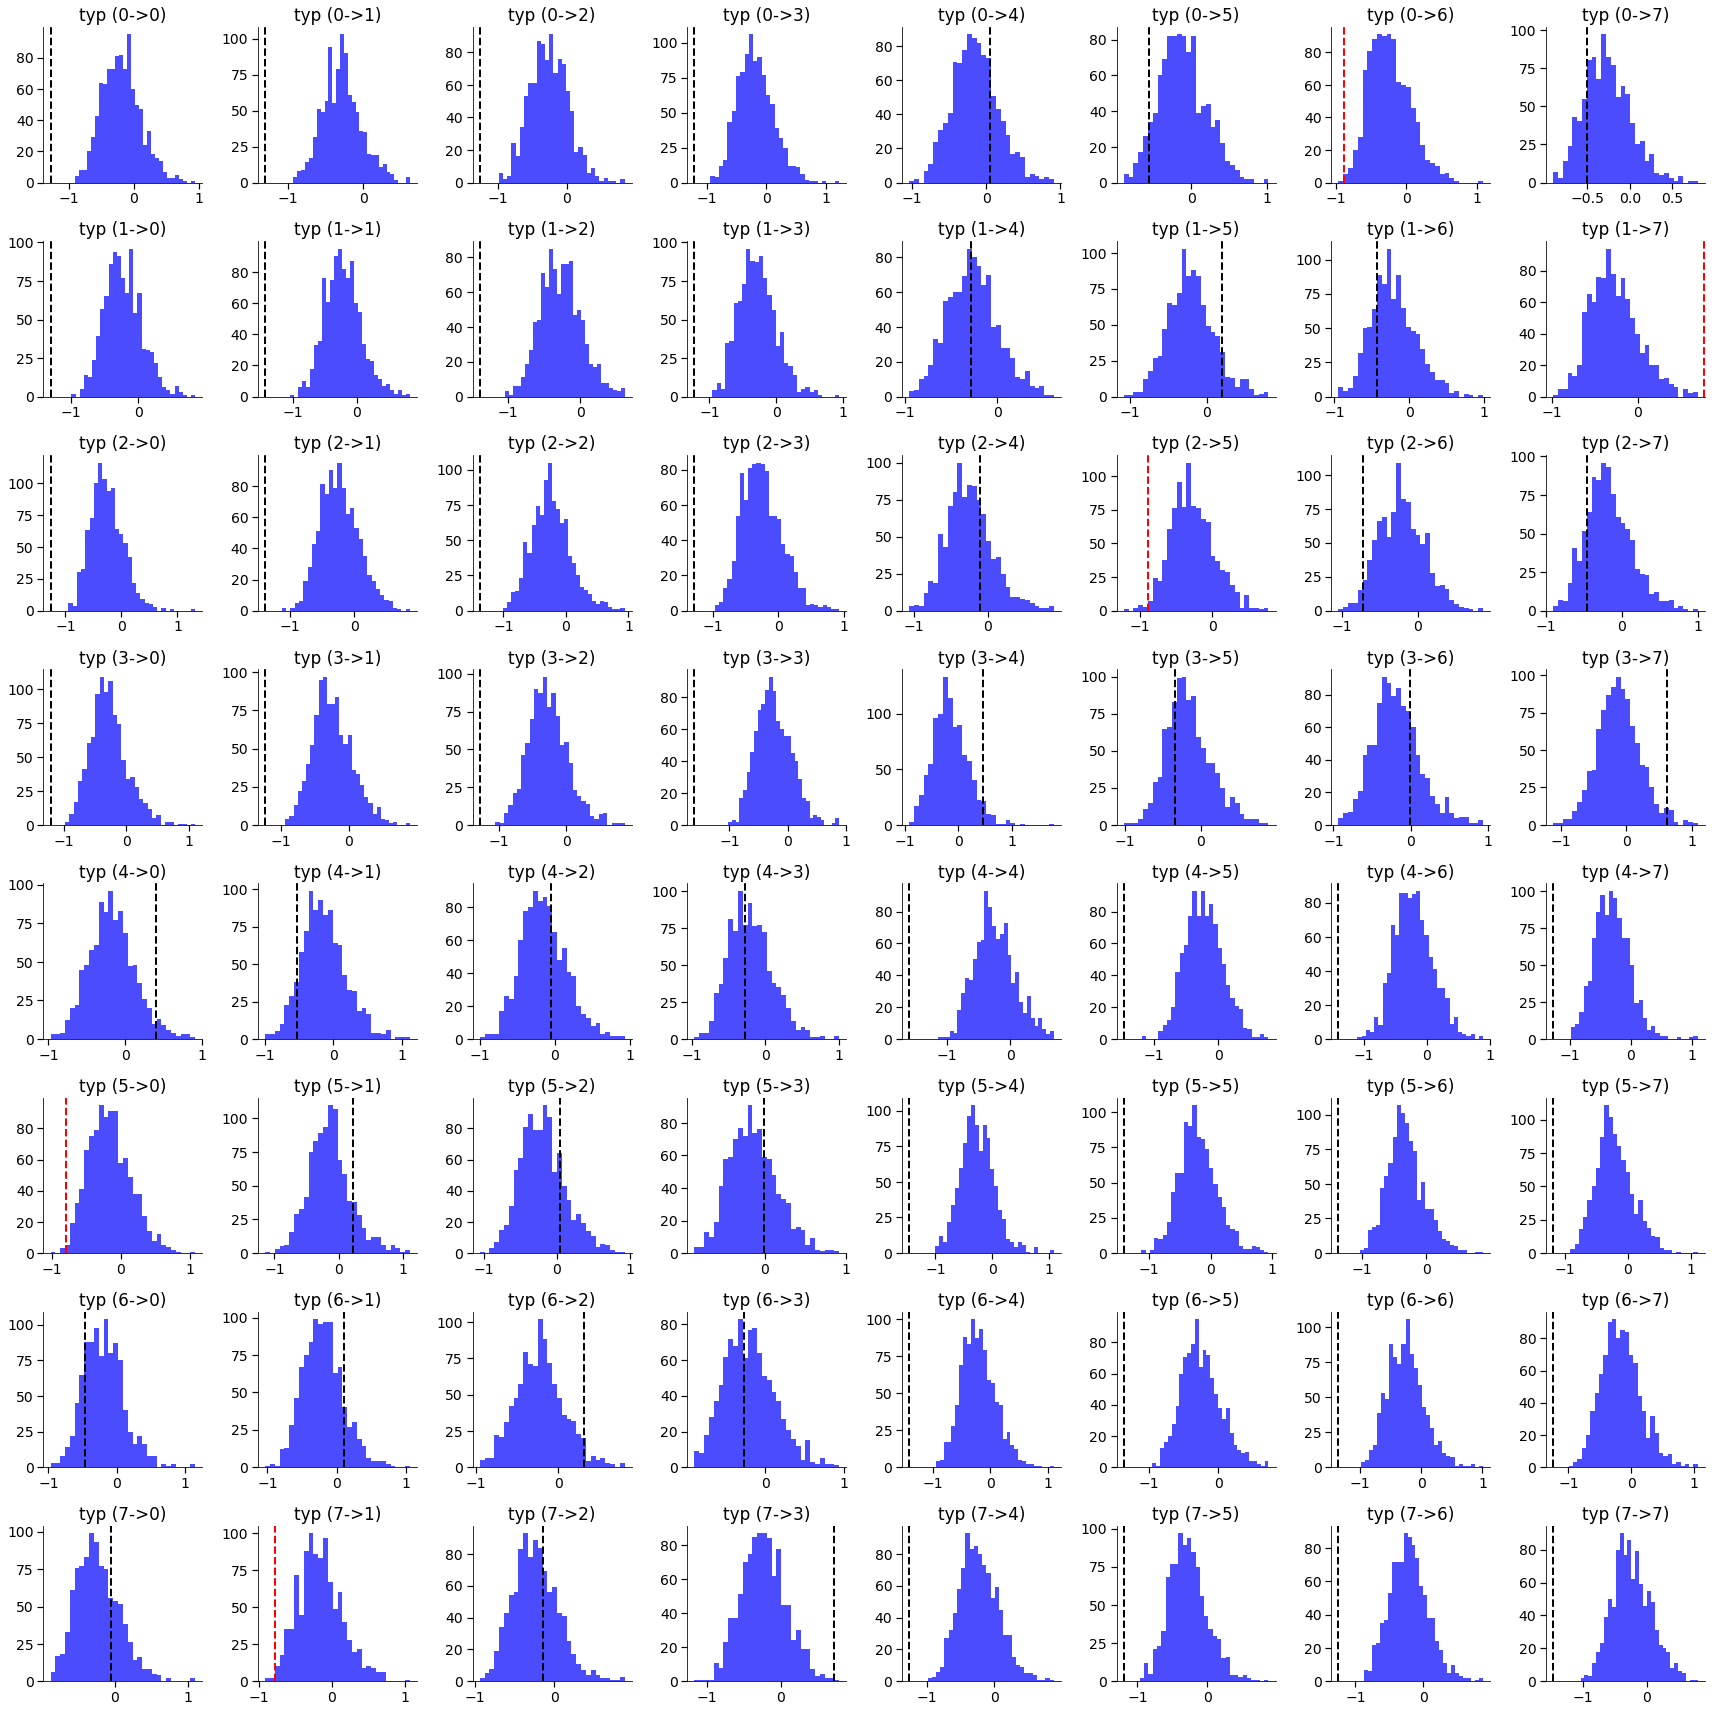

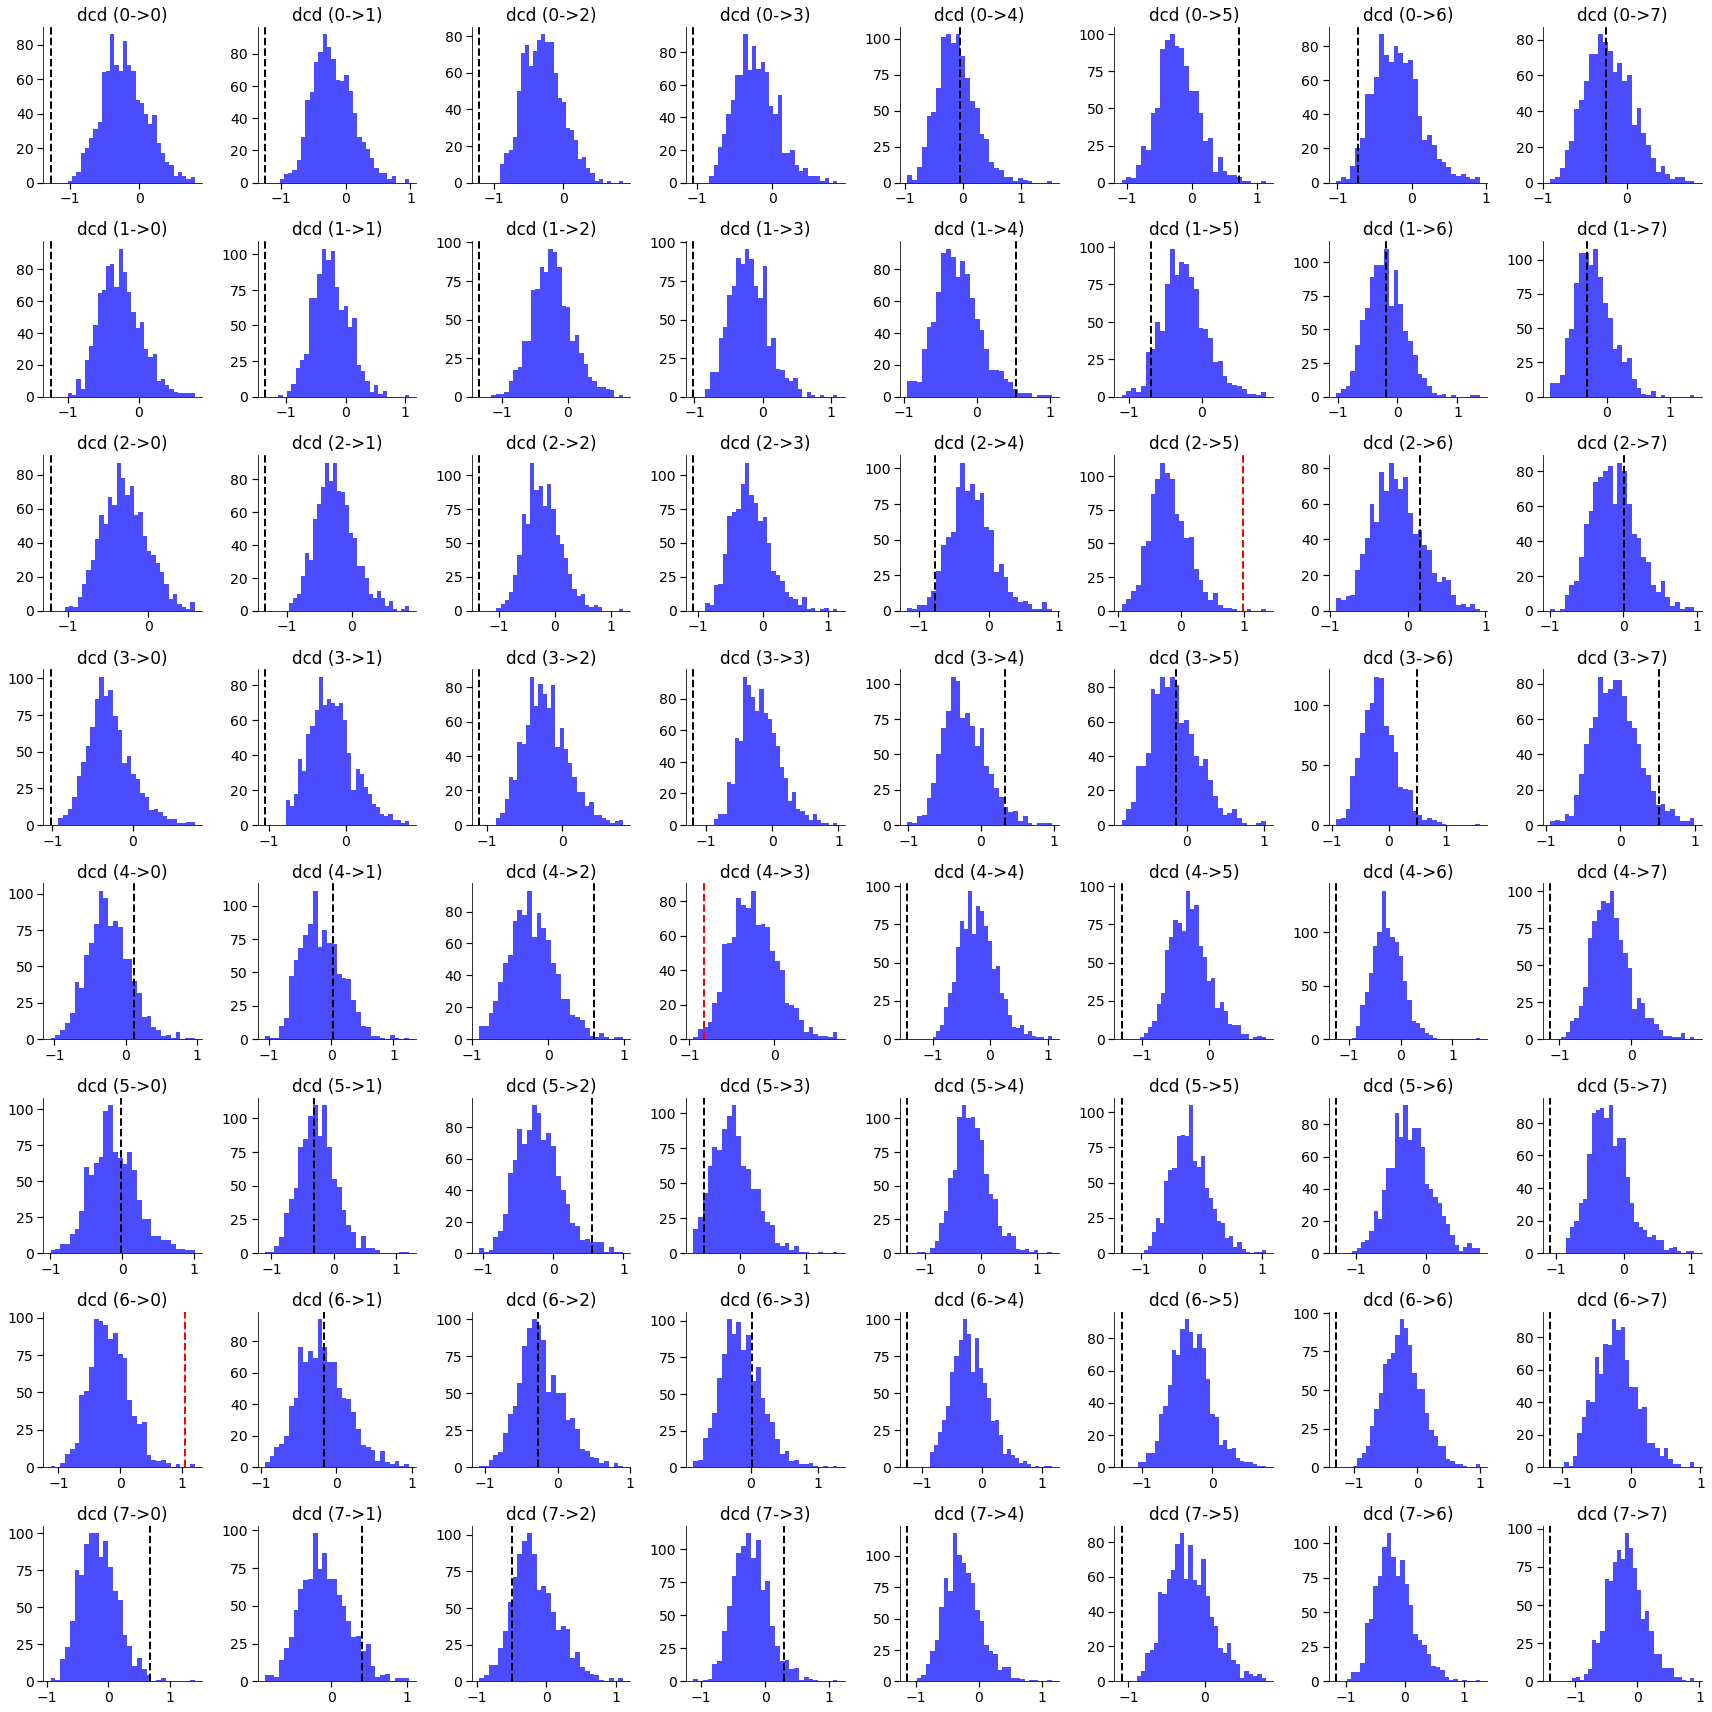

In [27]:
region_map = ['-'.join(label.split('-')[:-1]) for label in unit_labels]

# Initialize dictionaries to store corrected p-values
one_samp_p_values = {group: np.zeros((n_units, n_units)) for group in groups}

# Compute p-values for each matrix in each condition
for g_idx, group in enumerate(groups):
    observed_gc_matrix = np.mean(signed_gc_matrices[group], axis=0)  # Average across subjects
    permuted_gc_array = np.array(permuted_signed_gc_matrices[group])  # Convert to numpy array (shape: n_permutations x neurons x neurons)

    fig = plt.figure(figsize=(24, 24))
    gs = GridSpec(n_units, n_units)

    # Collect inter-regional p-values for FDR
    region_indices = []
    p_values_flat = []

    for i in range(n_units):
        for j in range(n_units):
            observed_value = observed_gc_matrix[i, j]
            null_distribution = permuted_gc_array[:, i, j]
            
            p_value = (np.sum(np.abs(null_distribution) >= np.abs(observed_value)) + 1) / (n_permutations + 1)
            region_indices.append((i, j))
            p_values_flat.append(p_value)
            
    # Apply FDR correction to inter-regional p-values only
    _, corrected_p_values_flat, _, _ = multipletests(p_values_flat, alpha=0.05, method='fdr_bh')

    # Fill corrected p-value matrix
    for (i, j), p_corr in zip(region_indices, corrected_p_values_flat):
        one_samp_p_values[group][i, j] = p_corr
        
    for i in range(n_units):
        for j in range(n_units):
            if region_map[i]==region_map[j]:
                one_samp_p_values[group][i,j]=1

    # Update plots based on corrected p-values
    for i in range(n_units):
        for j in range(n_units):
            observed_value = observed_gc_matrix[i, j]
            null_distribution = permuted_gc_array[:, i, j]
            ax = fig.add_subplot(gs[i, j])
            # Plot histogram of null distribution with observed value
            plt.hist(null_distribution, bins=30, alpha=0.7, color='blue', label='Permuted GC')
            plt.title(f"{group} ({i}->{j})")
            col = 'black'
            if one_samp_p_values[group][i, j] < 0.05:
                col = 'red'
            plt.axvline(x=observed_gc_matrix[i, j], color=col, linestyle='dashed', linewidth=2)
    
    plt.tight_layout()


In [28]:
# Store observed differences
n_typ = len(signed_gc_matrices['typ'])  # Number of subjects in 'typ'
n_dcd = len(signed_gc_matrices['dcd'])  # Number of subjects in 'dcd'

# Compute observed differences (mean difference between groups)
mean_typ = np.mean(signed_gc_matrices['typ'], axis=0)  # Mean across 'typ' subjects
mean_dcd = np.mean(signed_gc_matrices['dcd'], axis=0)  # Mean across 'dcd' subjects
observed_diff_gc = mean_dcd - mean_typ  # Shape: (neurons, neurons)

# Pool all data for permutation testing
all_data = np.vstack([signed_gc_matrices['typ'], signed_gc_matrices['dcd']])
n_total = n_typ + n_dcd

# Permutation testing
n_group_permutations = 10000
permuted_diff_gc_matrices = np.zeros((n_group_permutations, n_units, n_units))

for perm_idx in range(n_group_permutations):
    print(f'Permutation {perm_idx}')
    
    # Shuffle subject labels
    perm_indices = np.random.permutation(n_total)
    perm_typ = all_data[perm_indices[:n_typ]]  # Random subset as 'typ'
    perm_dcd = all_data[perm_indices[n_typ:]]  # Random subset as 'dcd'
    
    # Compute permuted mean differences
    perm_mean_typ = np.mean(perm_typ, axis=0)
    perm_mean_dcd = np.mean(perm_dcd, axis=0)
    permuted_diff_gc_matrices[perm_idx] = perm_mean_dcd - perm_mean_typ

# Compute p-values
p_values_diff = np.zeros((n_units, n_units))

for i in range(n_units):
    for j in range(n_units):
        observed_value = observed_diff_gc[i, j]
        null_distribution = permuted_diff_gc_matrices[:, i, j]
        
        # Compute two-tailed p-value
        p_values_diff[i, j] = (np.sum(np.abs(null_distribution) >= np.abs(observed_value)) + 1) / (n_group_permutations + 1)


Permutation 0
Permutation 1
Permutation 2
Permutation 3
Permutation 4
Permutation 5
Permutation 6
Permutation 7
Permutation 8
Permutation 9
Permutation 10
Permutation 11
Permutation 12
Permutation 13
Permutation 14
Permutation 15
Permutation 16
Permutation 17
Permutation 18
Permutation 19
Permutation 20
Permutation 21
Permutation 22
Permutation 23
Permutation 24
Permutation 25
Permutation 26
Permutation 27
Permutation 28
Permutation 29
Permutation 30
Permutation 31
Permutation 32
Permutation 33
Permutation 34
Permutation 35
Permutation 36
Permutation 37
Permutation 38
Permutation 39
Permutation 40
Permutation 41
Permutation 42
Permutation 43
Permutation 44
Permutation 45
Permutation 46
Permutation 47
Permutation 48
Permutation 49
Permutation 50
Permutation 51
Permutation 52
Permutation 53
Permutation 54
Permutation 55
Permutation 56
Permutation 57
Permutation 58
Permutation 59
Permutation 60
Permutation 61
Permutation 62
Permutation 63
Permutation 64
Permutation 65
Permutation 66
Permu

Permutation 1492
Permutation 1493
Permutation 1494
Permutation 1495
Permutation 1496
Permutation 1497
Permutation 1498
Permutation 1499
Permutation 1500
Permutation 1501
Permutation 1502
Permutation 1503
Permutation 1504
Permutation 1505
Permutation 1506
Permutation 1507
Permutation 1508
Permutation 1509
Permutation 1510
Permutation 1511
Permutation 1512
Permutation 1513
Permutation 1514
Permutation 1515
Permutation 1516
Permutation 1517
Permutation 1518
Permutation 1519
Permutation 1520
Permutation 1521
Permutation 1522
Permutation 1523
Permutation 1524
Permutation 1525
Permutation 1526
Permutation 1527
Permutation 1528
Permutation 1529
Permutation 1530
Permutation 1531
Permutation 1532
Permutation 1533
Permutation 1534
Permutation 1535
Permutation 1536
Permutation 1537
Permutation 1538
Permutation 1539
Permutation 1540
Permutation 1541
Permutation 1542
Permutation 1543
Permutation 1544
Permutation 1545
Permutation 1546
Permutation 1547
Permutation 1548
Permutation 1549
Permutation 15

Permutation 2979
Permutation 2980
Permutation 2981
Permutation 2982
Permutation 2983
Permutation 2984
Permutation 2985
Permutation 2986
Permutation 2987
Permutation 2988
Permutation 2989
Permutation 2990
Permutation 2991
Permutation 2992
Permutation 2993
Permutation 2994
Permutation 2995
Permutation 2996
Permutation 2997
Permutation 2998
Permutation 2999
Permutation 3000
Permutation 3001
Permutation 3002
Permutation 3003
Permutation 3004
Permutation 3005
Permutation 3006
Permutation 3007
Permutation 3008
Permutation 3009
Permutation 3010
Permutation 3011
Permutation 3012
Permutation 3013
Permutation 3014
Permutation 3015
Permutation 3016
Permutation 3017
Permutation 3018
Permutation 3019
Permutation 3020
Permutation 3021
Permutation 3022
Permutation 3023
Permutation 3024
Permutation 3025
Permutation 3026
Permutation 3027
Permutation 3028
Permutation 3029
Permutation 3030
Permutation 3031
Permutation 3032
Permutation 3033
Permutation 3034
Permutation 3035
Permutation 3036
Permutation 30

Permutation 4471
Permutation 4472
Permutation 4473
Permutation 4474
Permutation 4475
Permutation 4476
Permutation 4477
Permutation 4478
Permutation 4479
Permutation 4480
Permutation 4481
Permutation 4482
Permutation 4483
Permutation 4484
Permutation 4485
Permutation 4486
Permutation 4487
Permutation 4488
Permutation 4489
Permutation 4490
Permutation 4491
Permutation 4492
Permutation 4493
Permutation 4494
Permutation 4495
Permutation 4496
Permutation 4497
Permutation 4498
Permutation 4499
Permutation 4500
Permutation 4501
Permutation 4502
Permutation 4503
Permutation 4504
Permutation 4505
Permutation 4506
Permutation 4507
Permutation 4508
Permutation 4509
Permutation 4510
Permutation 4511
Permutation 4512
Permutation 4513
Permutation 4514
Permutation 4515
Permutation 4516
Permutation 4517
Permutation 4518
Permutation 4519
Permutation 4520
Permutation 4521
Permutation 4522
Permutation 4523
Permutation 4524
Permutation 4525
Permutation 4526
Permutation 4527
Permutation 4528
Permutation 45

Permutation 5968
Permutation 5969
Permutation 5970
Permutation 5971
Permutation 5972
Permutation 5973
Permutation 5974
Permutation 5975
Permutation 5976
Permutation 5977
Permutation 5978
Permutation 5979
Permutation 5980
Permutation 5981
Permutation 5982
Permutation 5983
Permutation 5984
Permutation 5985
Permutation 5986
Permutation 5987
Permutation 5988
Permutation 5989
Permutation 5990
Permutation 5991
Permutation 5992
Permutation 5993
Permutation 5994
Permutation 5995
Permutation 5996
Permutation 5997
Permutation 5998
Permutation 5999
Permutation 6000
Permutation 6001
Permutation 6002
Permutation 6003
Permutation 6004
Permutation 6005
Permutation 6006
Permutation 6007
Permutation 6008
Permutation 6009
Permutation 6010
Permutation 6011
Permutation 6012
Permutation 6013
Permutation 6014
Permutation 6015
Permutation 6016
Permutation 6017
Permutation 6018
Permutation 6019
Permutation 6020
Permutation 6021
Permutation 6022
Permutation 6023
Permutation 6024
Permutation 6025
Permutation 60

Permutation 7460
Permutation 7461
Permutation 7462
Permutation 7463
Permutation 7464
Permutation 7465
Permutation 7466
Permutation 7467
Permutation 7468
Permutation 7469
Permutation 7470
Permutation 7471
Permutation 7472
Permutation 7473
Permutation 7474
Permutation 7475
Permutation 7476
Permutation 7477
Permutation 7478
Permutation 7479
Permutation 7480
Permutation 7481
Permutation 7482
Permutation 7483
Permutation 7484
Permutation 7485
Permutation 7486
Permutation 7487
Permutation 7488
Permutation 7489
Permutation 7490
Permutation 7491
Permutation 7492
Permutation 7493
Permutation 7494
Permutation 7495
Permutation 7496
Permutation 7497
Permutation 7498
Permutation 7499
Permutation 7500
Permutation 7501
Permutation 7502
Permutation 7503
Permutation 7504
Permutation 7505
Permutation 7506
Permutation 7507
Permutation 7508
Permutation 7509
Permutation 7510
Permutation 7511
Permutation 7512
Permutation 7513
Permutation 7514
Permutation 7515
Permutation 7516
Permutation 7517
Permutation 75

Permutation 8966
Permutation 8967
Permutation 8968
Permutation 8969
Permutation 8970
Permutation 8971
Permutation 8972
Permutation 8973
Permutation 8974
Permutation 8975
Permutation 8976
Permutation 8977
Permutation 8978
Permutation 8979
Permutation 8980
Permutation 8981
Permutation 8982
Permutation 8983
Permutation 8984
Permutation 8985
Permutation 8986
Permutation 8987
Permutation 8988
Permutation 8989
Permutation 8990
Permutation 8991
Permutation 8992
Permutation 8993
Permutation 8994
Permutation 8995
Permutation 8996
Permutation 8997
Permutation 8998
Permutation 8999
Permutation 9000
Permutation 9001
Permutation 9002
Permutation 9003
Permutation 9004
Permutation 9005
Permutation 9006
Permutation 9007
Permutation 9008
Permutation 9009
Permutation 9010
Permutation 9011
Permutation 9012
Permutation 9013
Permutation 9014
Permutation 9015
Permutation 9016
Permutation 9017
Permutation 9018
Permutation 9019
Permutation 9020
Permutation 9021
Permutation 9022
Permutation 9023
Permutation 90

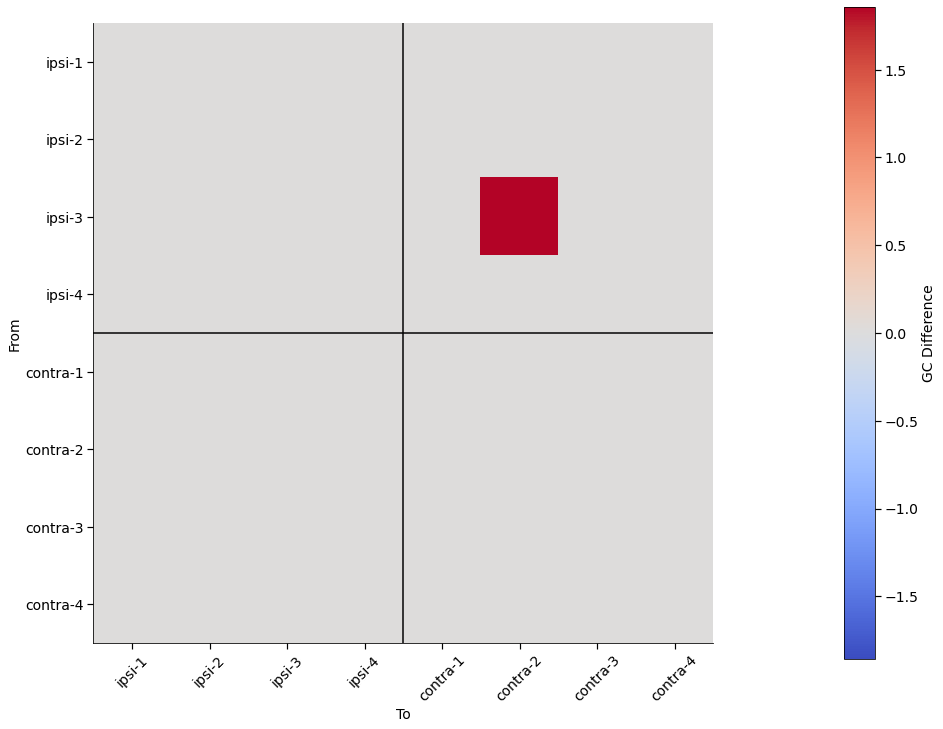

In [29]:
# Create a GridSpec for better layout control
fig = plt.figure(figsize=(14, 12))
gs = GridSpec(1, 2, width_ratios=[1, 0.05])

significant_diff_gc_matrix = copy.copy(observed_diff_gc)
significant_diff_gc_matrix[p_values_diff >= 0.05] = 0

# Dynamic clim based on the difference matrix
maxabs = np.max(np.abs(significant_diff_gc_matrix))

# Plot the GC difference
ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(significant_diff_gc_matrix, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_xticks(np.arange(len(unit_labels)))
ax.set_xticklabels(unit_labels, rotation=45)
ax.set_yticks(np.arange(len(unit_labels)))
ax.set_yticklabels(unit_labels)
plt.axvline(3.5,color='k')
plt.axhline(3.5,color='k')


# Add a single colorbar to the right
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_label('GC Difference', fontsize=14)

plt.subplots_adjust(wspace=0.4)
plt.show()


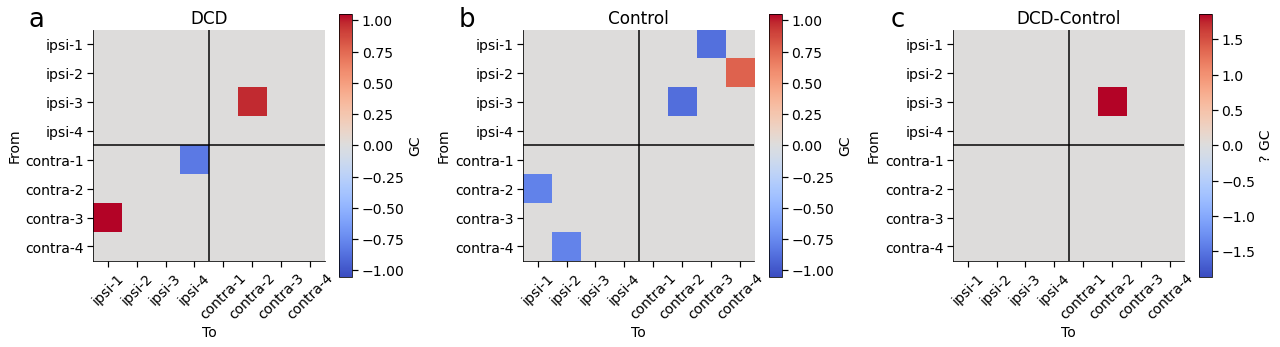

In [30]:
# Create a GridSpec for better layout control
fig = plt.figure(figsize=(6 * len(signed_gc_matrices)+6, 5))
gs = GridSpec(1, 3)

# Calculate a dynamic clim based on all conditions
all_gc_values = []
for cond in signed_gc_matrices:
    significant_gc_matrix = np.mean(np.array(signed_gc_matrices[cond]), axis=0)
    significant_gc_matrix[one_samp_p_values[cond] >= 0.05] = 0
    all_gc_values.extend(significant_gc_matrix.flatten())

common_clim = [-max(abs(np.min(all_gc_values)), np.max(all_gc_values)), max(abs(np.min(all_gc_values)), np.max(all_gc_values))]

ax = fig.add_subplot(gs[0, 0])
significant_gc_matrix = np.mean(np.array(signed_gc_matrices['dcd']), axis=0)
significant_gc_matrix[one_samp_p_values['dcd'] >= 0.05] = 0
# Display results
im = ax.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=common_clim)
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_xticks(np.arange(n_units))
ax.set_xticklabels(unit_labels, rotation=45)
ax.set_yticks(np.arange(n_units))
ax.set_yticklabels(unit_labels)
ax.set_title('DCD')
plt.axvline(3.5,color='k')
plt.axhline(3.5,color='k')
plt.colorbar(im, label='GC')
add_subplot_label(ax, 'a', y=1.1)


ax = fig.add_subplot(gs[0, 1])
significant_gc_matrix = np.mean(np.array(signed_gc_matrices['typ']), axis=0)
significant_gc_matrix[one_samp_p_values['typ'] >= 0.05] = 0
# Display results
im = ax.imshow(significant_gc_matrix, cmap='coolwarm', interpolation='none', clim=common_clim)
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_xticks(np.arange(n_units))
ax.set_xticklabels(unit_labels, rotation=45)
ax.set_yticks(np.arange(n_units))
ax.set_yticklabels(unit_labels)
ax.set_title('Control')
plt.axvline(3.5,color='k')
plt.axhline(3.5,color='k')
plt.colorbar(im, label='GC')
add_subplot_label(ax, 'b', y=1.1)
    
    
# Plot the GC difference
ax = fig.add_subplot(gs[0, 2])
significant_diff_gc_matrix = copy.copy(observed_diff_gc)
significant_diff_gc_matrix[p_values_diff >= 0.05] = 0
# Dynamic clim based on the difference matrix
maxabs = np.max(np.abs(significant_diff_gc_matrix))
im = ax.imshow(significant_diff_gc_matrix, cmap='coolwarm', interpolation='none', clim=[-maxabs, maxabs])
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_xticks(np.arange(len(unit_labels)))
ax.set_xticklabels(unit_labels, rotation=45)
ax.set_yticks(np.arange(len(unit_labels)))
ax.set_yticklabels(unit_labels)
ax.set_title('DCD-Control')
plt.axvline(3.5,color='k')
plt.axhline(3.5,color='k')
plt.colorbar(im, label='? GC')
add_subplot_label(ax, 'c', y=1.1)

plt.tight_layout()

plt.savefig('./manuscript/figx_c3c4_burst_connectivity_ipsi_contra.pdf',dpi=600)